In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [12]:
DEVICE = 'cpu'
# DEVICE = 'cuda'

## Computing the Lyapunov Spectrum
Below is a minimal, parallelized implementation of the method for computing the Lyapunov spectrum and covariant Lyapunov vectors of a flow presented in [Ginelli et al. (2007)](https://arxiv.org/abs/0706.0510). The method applies to autonomous ODEs with a global attractor:

$$
\dot {\mathbf{x}} = f(\mathbf{x})
$$

In the `run_lyapunov()` function, we evolve the state $\mathbf{x}$ of the system along with $k$ orthonormal vectors $\mathbf{V}^j$. Pytorch's `torch.func.jvp` allows us to calculate the product with the jacobian without computing the entire $N \times N$ jacobian and `torch.func.vmap` allows us to compute $k$ of these operations in parallel.

$$
\begin{align*}
\mathbf{x}_{n+1} &\vcentcolon= \mathbf{x}_n + \Delta t\, f(\mathbf{x}_n)\\
\mathbf{V}_{n+1}^j &\vcentcolon= \mathbf{V}_n^j + \Delta t \, \nabla f(\mathbf{x}_n)\, \mathbf{V}_n^j
\end{align*}
$$

At each step, we ensure that the vectors $\mathbf{V}^j$ remain orthogonal and normalized (orthonormal) by applying a QR decomposition:

$$
\begin{align*}
\mathbf{V}_{n+1} &= \mathbf{Q}_{n+1} \mathbf{R}_{n+1}\\
\mathbf{V}_{n+1} &\vcentcolon= \mathbf{Q}_{n+1}
\end{align*}
$$

where $\mathbf{Q}_{n+1}$ is a $N \times k$ orthonormal matrix and $\mathbf{R}_{n+1}$ is a $k \times k$ upper triangular matrix. The Lyapunov exponents are then computed from the diagonals of $\mathbf{R}$ the matrices:

$$
\lambda_j = \frac{1}{m-\lfloor m/2\rfloor} \sum_{i=\lfloor m/2\rfloor}^{m-1} \log|\mathbf{R}_{i+1}^{j\,j}|
$$

To compute the Lyapunov vectors at the $n$-th timestep, we use the recurrence relation:

$$
\mathbf{C}_{n} = \mathbf{R}_{n+1}^{-1} \mathbf{C}_{n+1}
$$

with $\mathbf{C}_{m} = \mathbf{I}$. Then, the covariant Lyapunov vectors are given by:

$$
\mathbf{v}_n^j = \mathbf{Q}_{n} \mathbf{C}_{n}^j
$$

### Summary of notation:

| Symbol | Description |
|--------|-------------|
| $\mathbf{x}_n$ | $N$-dimensional state of the system at timestep $n$ |
| $\lambda_j$ | $j$-th largest Lyapunov exponent |
| $\mathbf{V}_n^j$ | $N$-dimensional tangent vector at timestep $n$ corresponding to Lyapunov exponent $\lambda_j$ |
| $\mathbf{Q}_n$ | matrix or orthonormal basis vectors from QR decomposition of $\mathbf{V}_n$ |
| $\mathbf{R}_n$ | upper triangular $k \times k$ matrix from QR decomposition of $\mathbf{V}_n$ |
| $\mathbf{v}_n^j$ | $N$-dimensional covariant Lyapunov vector at timestep $n$ corresponding to Lyapunov exponent $\lambda_j$ |
| $\mathbf{C}_n$ | upper triangular $k \times k$ "change of basis" matrix mapping $\mathbf{Q}_n$ to $\mathbf{v}_n$ |

In [14]:
from torch.func import jvp, vmap

def tangent_step(f, x: torch.Tensor, V: torch.Tensor, dt):
    def inner(v_col):
        # Single-direction JVP: returns only the JVP, we ignore primal_out.
        _, jv = jvp(f, (x,), (v_col,))
        return v_col + dt * jv

    # vmap the jvp op over the columns of V
    return vmap(inner)(V.T).T

def run_lyapunov(f, x0, V0, dt, steps, hold_at_origin=False, clv_steps=0, return_vectors=False):
    x = x0.clone().detach()
    V = V0.clone().detach()  # initial Gram-Schmidt basis  (k columns)
    k = V.shape[1]

    S = torch.zeros((steps, k), dtype=torch.float32, device=x.device)  # log diag(R)
    Rs = []  # store QR data

    x_n = torch.zeros_like(x0)
    V_n = torch.zeros_like(V0)
    n = steps - clv_steps - 1

    if hold_at_origin:
        h = int(np.sqrt(x.shape[0]).round())
        i, j = torch.meshgrid(
            torch.arange(h, device=x.device),
            torch.arange(h, device=x.device),
            indexing="ij",
        )
        i_idx, j_idx = i.flatten(), j.flatten()

    # ---------- forward QR pass ----------
    for step in tqdm(range(steps), leave=False, desc="forward"):
        # optional translation of origin
        if hold_at_origin:
            sA = torch.sum(x) + 1e-12
            mi = torch.sum(i_idx * x) / sA
            mj = torch.sum(j_idx * x) / sA
            sh = [h // 2 - int(mi), h // 2 - int(mj)]
            x = torch.roll(x.reshape(h, h), sh, (0, 1)).flatten()
            V = torch.roll(V.reshape(h, h, -1), sh, (0, 1)).reshape_as(V)
        
        # --- push tangent vectors forward ---
        W = tangent_step(f, x, V, dt)

        # --- QR orthonormalisation ---
        Q, R = torch.linalg.qr(W, mode="reduced")
        V = Q  # next GS basis
        
        # --- integrate the state ---
        x = x + dt * f(x)

        if step == n:
            x_n = x.clone()
            V_n = V.clone()
        if step > n:
            Rs.append(R)

        S[step] = torch.log(torch.abs(torch.diagonal(R)))

    # ---------- Lyapunov exponents ----------
    half = steps // 2
    S_cum = S.cumsum(0)
    counts = torch.arange(1, steps + 1, device=S.device, dtype=S.dtype).unsqueeze(1)
    lambda_history = S_cum / (counts * dt)
    # sliding window over last half
    lambda_history[half:] = (S_cum[half:] - S_cum[:-half]) / (half * dt)

    lambdas = lambda_history[-1]
    order = torch.argsort(lambdas, descending=True)

    results = [lambdas[order], lambda_history[:,order], x_n]
    if return_vectors:
        # ---------- GS orthonormal basis ----------
        GSV_n = V_n.clone()  # GS basis at final step

        # ---------- CLV reconstruction  ----------
        C = torch.eye(k, dtype=torch.float32, device=x.device)   # start at t_m
        for i, R in enumerate(reversed(Rs)):
            C = torch.linalg.solve_triangular(R, C, upper=True)  # C <- R^{-1}C
            if i % 100 == 0:
                C = C / torch.linalg.norm(C, dim=0, keepdim=True)  # normalise for stability

        CLV_n = (GSV_n @ C)[:, order].clone()  # CLVs at final step
        CLV_n = CLV_n / torch.linalg.norm(CLV_n, dim=0, keepdim=True)

        results.append(GSV_n[:,order]) # Gram-Schmidt orthonormal basis at m_th step
        results.append(CLV_n[:,order]) # Covariant Lyapunov vectors at m_th step

    return tuple(results)


def KY_dim(les):
    les = np.where(np.abs(les) < 1e-3, 0.0, les)  # round near zero exponents
    les = np.sort(np.asarray(les))[::-1]
    c = np.cumsum(les)
    if np.all(c >= 0):
        return float(len(les))
    j = np.where(c >= 0)[0][-1]
    return (j + 1) + c[j] / abs(les[j + 1])


## Example: Lorenz System
Let's test the above code to see if it gives us the expected result for the Lorenz system. For the parameter setting $\sigma=10$, $\beta=8/3$, and $\rho=28$, the Lorenz attractor is known to have Lyapunov exponents:

$$
\lambda_1 \approx 0.9, \quad \lambda_2 \approx 0.0, \quad \lambda_3 \approx -14.6
$$

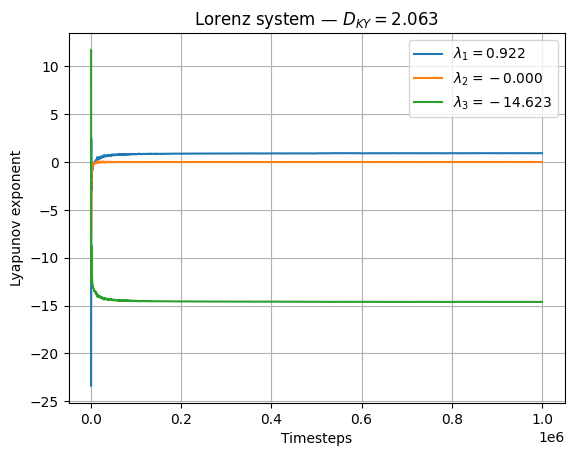

In [31]:
# evolution function for the Lorenz system
def lorenz(x):
    return torch.stack([10*(x[1]-x[0]), x[0]*(28-x[2])-x[1], x[0]*x[1]-8/3*x[2]])

x0 = torch.tensor([1.,1.,1.], dtype=torch.float32, requires_grad=True)
k = 3
N = x0.numel()
V0 = torch.randn(N, k, dtype=torch.float32)
Q, _ = torch.linalg.qr(V0)
V0 = Q
dt = 0.001
steps = 1000000
LEs, LEs_history, _  = run_lyapunov(lorenz, x0, V0, dt, steps, hold_at_origin=False, return_vectors=False)

plt.title("Lorenz system — $D_{KY}=" + f"{KY_dim(LEs):0.3f}" + "$")
plt.plot(LEs_history[:,0], label="$\lambda_1 =" + f"{LEs[0]:0.3f}" + "$")
plt.plot(LEs_history[:,1], label="$\lambda_2 =" + f"{LEs[1]:0.3f}" + "$")
plt.plot(LEs_history[:,2], label="$\lambda_3 =" + f"{LEs[2]:0.3f}" + "$")
plt.xlabel("Timesteps")
plt.ylabel("Lyapunov exponent")
plt.grid()
plt.legend();

## Asymptotic Lenia
Now let's load in some solutions from the Asymptotic Lenia system and evaluate their Lyapunov Exponents

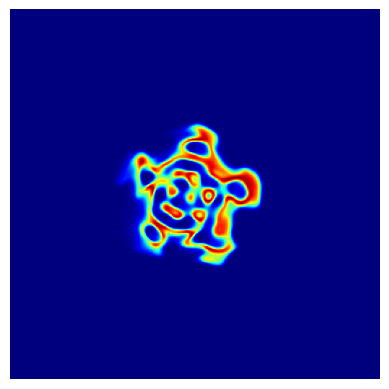

In [15]:
# params = {"R":18,"T":10,"b":[1,1/2,1/2,1],"m":0.24,"s":0.02,"kn":1,"gn":1, "filename": "soliton.npy"}
# params = {"R":18,"T":10,"b":[1,1/2,1/2,1],"m":0.2,"s":0.013,"kn":1,"gn":1, "filename": "periodic_soliton.npy"}
# params = {"R":18,"T":10,"b":[1,0.01,0.5,1],"m":0.22,"s":0.026,"kn":1,"gn":1, "filename": "rotator.npy"}
params = {"R":18,"T":10,"b":[1,0.01,0.25,1],"m":0.175,"s":0.0135,"kn":1,"gn":1, "filename": "chaotic_soliton.npy"}

A_glider = torch.tensor(np.load(params['filename']), dtype=torch.float32)
plt.imshow(A_glider, cmap='jet')
plt.axis('off');

In [16]:
def poly_kernel(r):
    return (4*r*(1-r))**4

def build_kernel(b, R, H):
    B = np.array(b.size)
    mid = H // 2
    Dx, Dy = np.meshgrid(np.arange(-mid, mid), np.arange(-mid, mid), indexing='ij')
    D = np.sqrt(Dx**2 + Dy**2) / R * B

    K = (D<B) * poly_kernel(D % 1) * b[np.minimum(D.astype(np.int64), B-1)]
    K = K / np.sum(K)
    K_fft = np.fft.fft2(np.fft.fftshift(K))
    return K_fft

scale = 3
H, W = (256, 256)

b = np.array(params['b'])
R = params['R'] * scale
m = params['m']
s = params['s']
T = params['T']

K_fft = build_kernel(b, R, H)
K_fft = torch.tensor(K_fft, dtype=torch.complex64).to(DEVICE)
m = torch.tensor(m, dtype=torch.float32).to(DEVICE)
s = torch.tensor(s, dtype=torch.float32).to(DEVICE)

def poly_growth(U,m=m,s=s):
    G = torch.maximum(torch.tensor(0), 1 - ((U-m)/s)**2 / 9 )**4 * 2 - 1
    return (G+1)/2

def convK(A, K_fft=K_fft):
    return torch.fft.ifft2(torch.fft.fft2(A) * K_fft).real

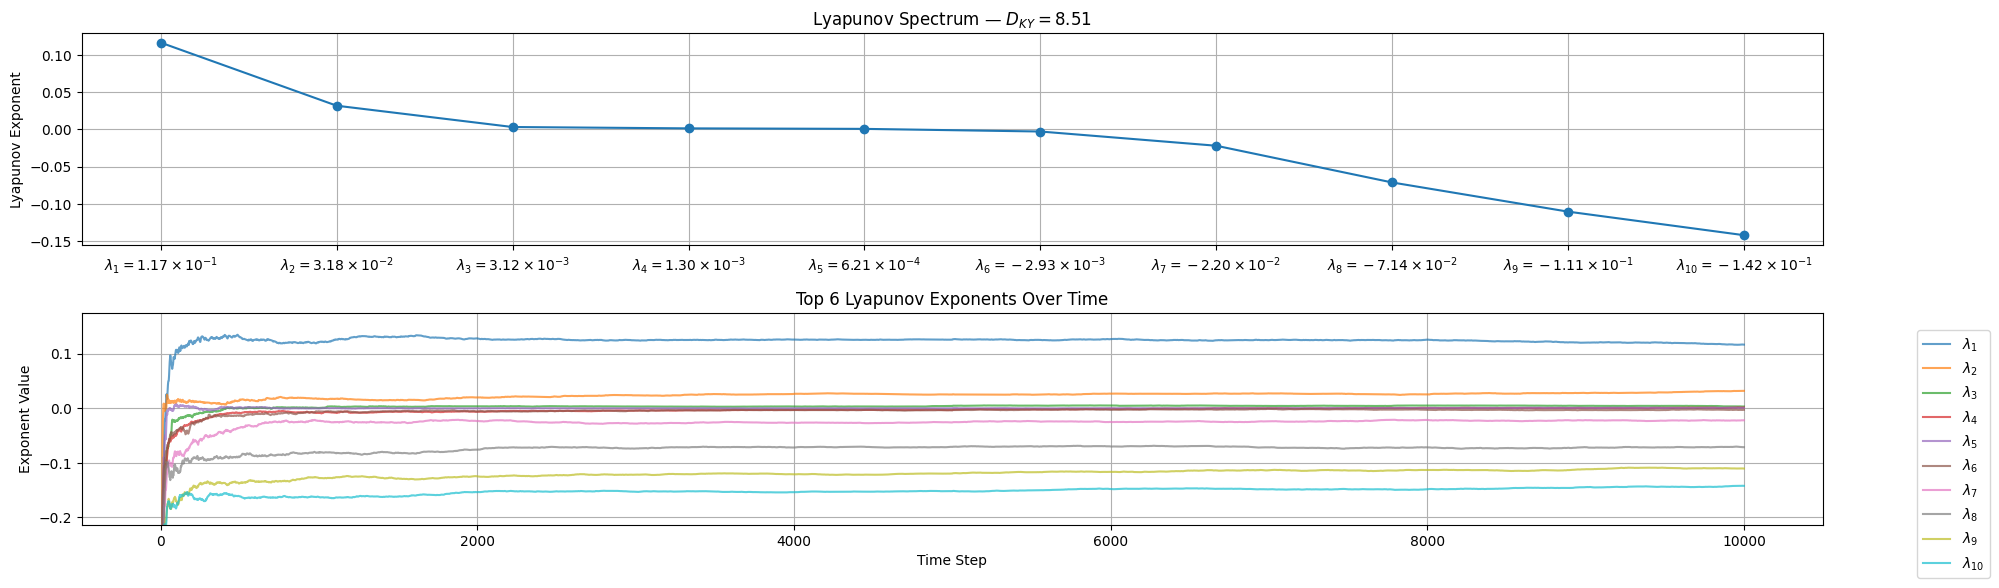

In [17]:
def lenia_step(X):
    A = X.reshape(H, W)
    return (poly_growth(convK(A),m=m,s=s) - A).flatten()  # T(K*A) - A

k = 10
H, W = A_glider.shape
X0 = A_glider.flatten().to(DEVICE)
# Randomly initialize the tangent vectors
V0 = torch.randn(X0.numel(), k, dtype=torch.float32)
Q, _ = torch.linalg.qr(V0)
V0 = Q.to(DEVICE)

# Run the Lyapunov exponent and CLV calculation
lyapunov_exponents, histories, A_final, GSV, CLV = run_lyapunov(lenia_step, X0, V0, 1/T, 100000, clv_steps=5000, hold_at_origin=True, return_vectors=True)

# Save the exponents, histories, clvs and final state for plotting
lyapunov_exponents = lyapunov_exponents.cpu().detach().numpy()
histories = histories.cpu().detach().numpy()
clvs = CLV.reshape(H,W,-1).cpu().detach().numpy()
A_final.reshape(H,W).cpu().detach().numpy()
np.savetxt(params['filename'].replace('.npy','_les.txt'), lyapunov_exponents)
np.save(params['filename'].replace('.npy','_les_histories.npy'), histories)
np.save(params['filename'].replace('.npy','_clvs.npy'), clvs)
np.save(params['filename'].replace('.npy','_final.npy'), A_final)

# Kaplan-Yorke dimension
D_KY = KY_dim(lyapunov_exponents)

plt.figure(figsize=(20, 6))
plt.subplot(2, 1, 1)
plt.plot(np.arange(k)+1, lyapunov_exponents, 'o-')
labels = []
for i, v in enumerate(lyapunov_exponents):
    mantissa, exponent = f"{v:.2e}".split('e')
    labels.append(f"$\\lambda_{{{i+1}}}={mantissa}\\times10^{{{int(exponent)}}}$")
plt.xticks(np.arange(k) + 1, labels, rotation=0)
plt.ylabel('Lyapunov Exponent')
plt.title('Lyapunov Spectrum — $D_{KY} ='+' {:.2f}$'.format(D_KY))
plt.grid(True, which='both')
plt.subplot(2, 1, 2)
cmap = plt.cm.tab10
colors = cmap(np.linspace(0, 1, histories.shape[1]))
for i in range(histories.shape[1]):
    plt.plot(histories[::10, i], color=colors[i], alpha=0.7, label='$\lambda_{'+str(i+1)+'}$')
lmin = lyapunov_exponents[-1] * 1.5
lmax = lyapunov_exponents[0] * 1.5
plt.ylim(lmin, lmax)
plt.xlabel('Time Step')
plt.ylabel('Exponent Value')
plt.title('Top 6 Lyapunov Exponents Over Time')
plt.legend(bbox_to_anchor=(1.05, 0.95), loc='upper left')
plt.grid(True)
plt.tight_layout()

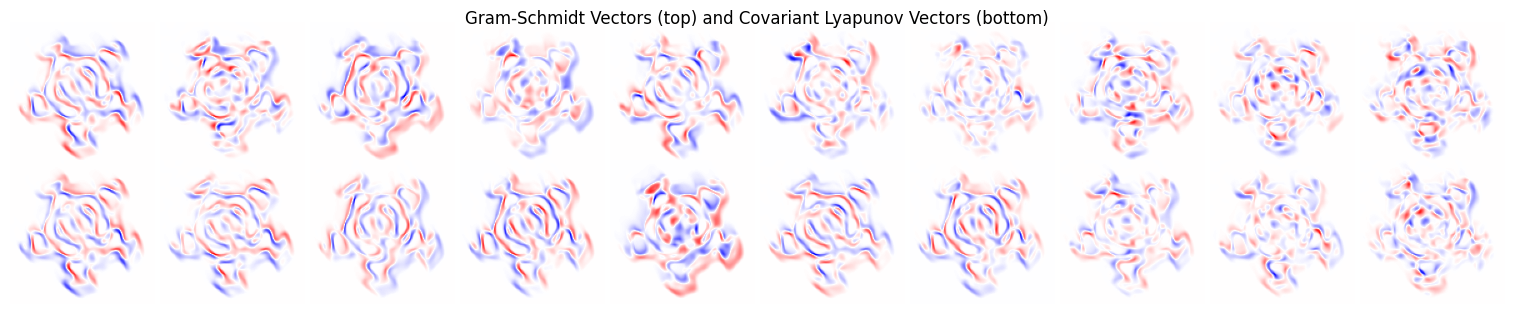

In [30]:
clvs = CLV.reshape(H,W,-1).cpu().detach().numpy()
gsvs = GSV.reshape(H,W,-1).cpu().detach().numpy()
fig = plt.figure(figsize=(15, 3))
for i in range(k):
    plt.subplot(2, k, i+1)
    vector = gsvs[..., i]
    max_abs_val = np.max(np.abs(vector))
    plt.imshow(vector[70:-70,70:-70], cmap='bwr', vmin=-max_abs_val, vmax=max_abs_val)
    # plt.title(f'{i+1}st Gram-Schmidt Vector')
    plt.axis('off')
    
    plt.subplot(2, k, i+1+k)
    vector = clvs[..., i]
    max_abs_val = np.max(np.abs(vector))
    plt.imshow(vector[70:-70,70:-70], cmap='bwr', vmin=-max_abs_val, vmax=max_abs_val)
    # plt.title(f'{i+1}st Covariant Lyapunov Vector')
    plt.axis('off')

plt.suptitle('Gram-Schmidt Vectors (top) and Covariant Lyapunov Vectors (bottom)')
plt.tight_layout(pad=0)
